# マルチエージェント強化学習
ここで実装しようと思っているもの
- 普通の繰り返し囚人のジレンマ+無学習エージェント(Axelrodのやつ)
- 普通の繰り返し囚人のジレンマ+強化学習エージェント(Q-learning, Minimax Q-learning,MQubed...) 
- 空間囚人のジレンマ+無学習エージェント
- 空間囚人のジレンマ+強化学習エージェント  

ネットワーク構造と内部状態の伝播方法を工夫しよう

In [1]:
# from __future__ import division
import numpy as np
import random
import collections
import warnings
from operator import itemgetter
import warnings
import pulp
warnings.filterwarnings('ignore') #warning表示なし
import networkx as nx
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib import animation
plt.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm

## ネットワークの可視化実験

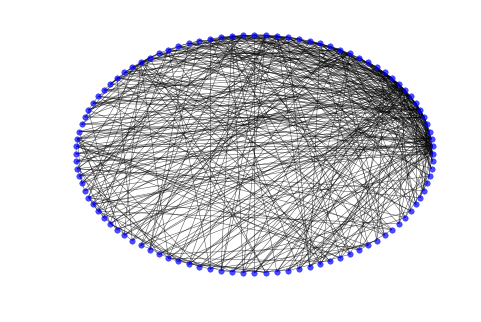

In [2]:
#べきグラフ
G = nx.powerlaw_cluster_graph(100, 5, 0.2)
nx.draw_circular(G, node_color='b', node_size=30, width=0.5, alpha=0.7)

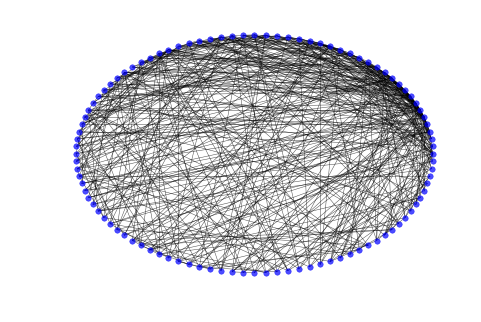

In [3]:
#BAグラフ
G = nx.barabasi_albert_graph(100, 5)
nx.draw_circular(G, node_color='b', node_size=30, width=0.5, alpha=0.7)

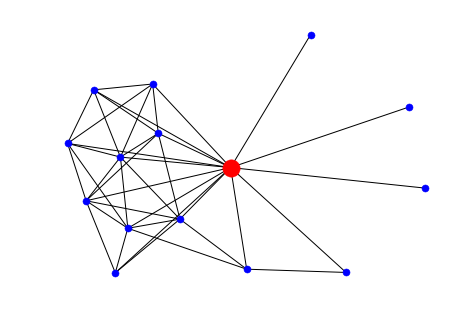

In [4]:
#ワッツストロガッツ ego グラフ
G = nx.watts_strogatz_graph(100, 10, 0.2)
# find node with largest degree
node_and_degree=G.degree()
(largest_hub,degree)=sorted(node_and_degree.items(),key=itemgetter(1))[-1]
# Create ego graph of main hub
hub_ego=nx.ego_graph(G,largest_hub) #largest_hubはnodeのid
pos=nx.spring_layout(hub_ego)
# Draw ego as large and red
nx.draw(hub_ego,pos,node_color='b',node_size=50,with_labels=False)
nx.draw_networkx_nodes(hub_ego,pos,nodelist=[largest_hub],node_size=300,node_color='r')
plt.show()

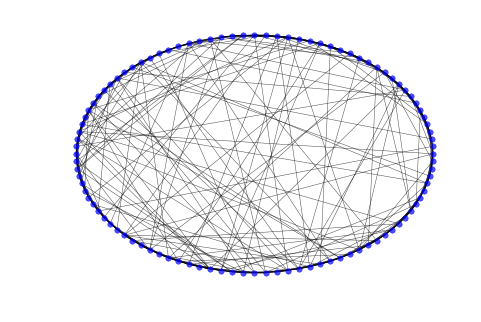

In [5]:
#ワッツストロガッツグラフ
G = nx.watts_strogatz_graph(100, 10, 0.2)
nx.draw_circular(G, node_color='b', node_size=30, width=0.5, alpha=0.7)

[n人ネットワークの繰り返し囚人のジレンマゲームにおける利得設計](https://kaigi.org/jsai/webprogram/2010/pdf/93.pdf)に対象環境にて定義されたネットワーク

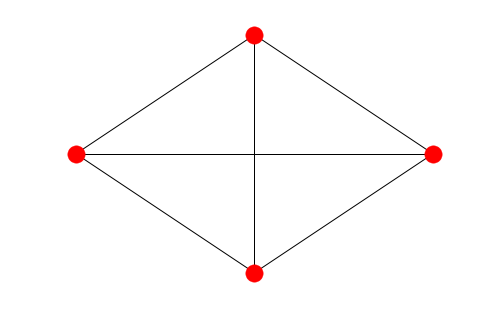

In [6]:
G_b = nx.from_numpy_matrix(np.array([[0, 1, 1], [1, 0, 1],[1, 1, 0]])) #(b)
G_c = nx.from_numpy_matrix(np.array([[0, 1, 0, 1], [1, 0, 1, 0],[0, 1, 0, 1],[1, 0, 1, 0]])) #(c)
G_d = nx.from_numpy_matrix(np.array([[0, 1, 1, 1], [1, 0, 1, 0],[1, 1, 0, 1],[1, 0, 1, 0]])) #(d)
G_e = nx.from_numpy_matrix(np.array([[0, 1, 1, 1], [1, 0, 1, 1],[1, 1, 0, 1],[1, 1, 1, 0]])) #(e)
nx.draw_circular(G_e)

### 繰り返しゲームでの強化学習

TODO : axelrodとかを参考にして無学習エージェントを実装する for 教師あり  
zero-sumにする or general-sumにする  
参考文献：  
[囚人のジレンマゲームにおけるQ学習による協調の維持](https://www.jstage.jst.go.jp/article/jssst/25/4/25_4_4_145/_pdf)  
[繰り返しゲームでの強化学習アルゴリズムの組み合わせによる協調行動の学習](https://kaigi.org/jsai/webprogram/2014/pdf/654.pdf)  
[Learning to compete, compromise, and cooperate in repeated general-sum games](http://www.machinelearning.org/proceedings/icml2005/papers/021_Learning_CrandallGoodrich.pdf)  
[Multi-agent Learning Experiments on Repeated Matrix Games](http://machinelearning.wustl.edu/mlpapers/paper_files/icml2010_BouzyM10.pdf)  
[Learning to compete, coordinate, and cooperate
in repeated games using reinforcement learning](http://download.springer.com/static/pdf/352/art%253A10.1007%252Fs10994-010-5192-9.pdf?originUrl=http%3A%2F%2Flink.springer.com%2Farticle%2F10.1007%2Fs10994-010-5192-9&token2=exp=1493532238~acl=%2Fstatic%2Fpdf%2F352%2Fart%25253A10.1007%25252Fs10994-010-5192-9.pdf%3ForiginUrl%3Dhttp%253A%252F%252Flink.springer.com%252Farticle%252F10.1007%252Fs10994-010-5192-9*~hmac=68c20f793ff1721ffe4336508eacbee47862c30ab2490ac117798f3d179f2695)  
[Jonatan Milewski MultiAgent Reinforcement Learning](https://www.cs.ubc.ca/~kevinlb/teaching/cs532l%20-%202013-14/Lectures/rl-pres.pdf)

### 各種ゲームマトリックスの定義

In [2]:
#(agent0の利得, agent1の利得)
#action文字列, payoff matrix
def rock_paper_scissors():
    return np.array(['r', 'p', 's']), np.array([[(0,0),(-1,1),(1,-1)],[(1,-1),(0,0),(-1,1)],[(-1,1),(1,-1),(0,0)]])

def shapleys_game():
    return np.array(['a', 'b', 'c']), np.array([[(0,0),(0,1),(1,0)],[(1,0),(0,0),(0,1)],[(0,1),(1,0),(0,0)]])

def matching_pennies():
    return np.array(['a', 'b']), np.array([[(1,-1), (-1,1)],[(-1,1), (1,-1)]])

def coodination_game():
    return np.array(['a', 'b']),np.array([[(2,2), (0,0)],[(0,0), (4,4)]])

def stag_hunt():
    return np.array(['a', 'b']),np.array([[(2,2), (3,-5)],[(-5,3), (4,4)]])

def prisoners_dilemma():
    return np.array(['c', 'd']),np.array([[(3,3), (0,5)],[(5,0), (1,1)]])

def chicken_game():
     return np.array(['c', 'd']),np.array([[(3,3), (2,3.5)],[(3.5,2), (1,1)]])
    
def tricky_game():
     return np.array(['a', 'b']),np.array([[(0,3), (3,2)],[(1,0), (2,1)]])

In [7]:
problem = pulp.LpProblem('Problem Name', pulp.LpMaximize)
c1 = pulp.LpVariable('c1', 0, 1)
d1 = pulp.LpVariable('d1', 0, 1)
_, payoff_matrix = matching_pennies()
problem += (payoff_matrix[0][0][0]+payoff_matrix[0][1][0])/2*c1 + (payoff_matrix[1][0][0]+payoff_matrix[1][1][0])/2*d1
problem += c1 + d1 == 1
problem.solve()
print(c1.value(), d1.value())

1.0 0.0


#### 実装するアルゴリズム
- Q Learning
- Nash Q Learning
- minimaxQ
- Belied-based Reinforcement Learning
- M-Qubed
- Satisficing Algorithm

In [3]:
#ボルツマンソフトマックス方策
def softmax_boltzman(q_row, T=1.0):
    """
    @param q_row q_table row of object state s
    @param T temperature parameter
    @return selected action arg
    """
    obj = np.arange(len(q_row))[np.invert(np.isnan(q_row))] #隣接していないをNoneで表す
    q_row = q_row[np.invert(np.isnan(q_row))]
    #TODO Tの温度管理を実装
    return np.random.choice(obj, p=(np.exp(q_row / T))/np.sum(np.exp(q_row / T)))

In [4]:
def eps_greedy(q_row, eps=0.05):
    """
    @param q_row q_table row of object state s
    @param eps epsilon
    @return selected action arg
    """
    q_row = np.array(q_row)
    obj = np.arange(len(q_row))[np.invert(np.isnan(q_row))]
    if np.random.rand() < eps:
        return np.random.choice(obj) #randomに戦略を返す
    else:
        return obj[np.argmax(q_row)] #最高のものを返す

In [5]:
class Q_Learning_Agent:
    def __init__(self, agent_id, neighbors, state_set, action_set, gamma=0.9):
        self.agent_id = agent_id
        self.neighbors = neighbors
        self.action_set = action_set #action文字列の集合
        self.state_set = state_set #state文字列の集合
        self.gamma = gamma
        self.reward_lst = [] #長さ制限つける？
        self.prev_action = None
        self.current_state = 0 #今は1カラムだけだから0にしてるけど問題あり!!
        #indexが縦，columnsは横, 楽観的初期値の時はnp.onesにする
        self.q_table = pd.DataFrame(np.zeros((len(action_set), len(state_set))), index=self.action_set, columns=self.state_set)
        
    def re_init(self):
        self.reward_lst = []
        self.q_table = pd.DataFrame(np.zeros((len(action_set), len(state_set))), index=self.action_set, columns=self.state_set)
        
    def get_neighbors(self):
        return self.neighbors
    
    def update_q(self, state, reward,alpha=0.1):
        a = self.action_set[self.prev_action] #今回行うアクション
        self.reward_lst.append(reward)
        self.q_table[self.current_state][a] += alpha*(reward+self.gamma * np.nanmax(np.array(self.q_table[state], dtype=np.float64))-self.q_table[self.current_state][a]) #q_table[state][action]
        self.current_state = state
        
    def act(self, state, random=False):
        """
        適格度トレースを入れる時はactionのmemoryを入れる必要あり
        """
        if random:
            action = np.random.choice([0, 1])
        else:
            q_row = self.q_table[state]
            action = eps_greedy(q_row)
        self.prev_action = action
        return self.prev_action #0 もしくは 1を返す, 0->coop, 1->comp

In [6]:
class M_Qubed_Agent:
    def __init__(self, agent_id, neighbors, state_set, action_set, gamma=0.95, n_observe=10):
        self.agent_id = agent_id
        self.neighbors = neighbors
        self.action_set = action_set #action文字列の集合
        self.state_set = state_set #state文字列の集合
        self.gamma = gamma
        self.n_act = 0
        self.reward_lst = [] #長さ制限つける？
        self.alpha = np.random.rand()
        self.ita = np.random.rand()
        self.beta = 0
        self.beta_d = 0
        self.n_observe=  n_observe
        self.estimate_h = np.nan
        self.estimate_l = np.nan
        self.pi = 
        self.prev_action = None
        self.current_state = 0 #今は1カラムだけだから0にしてるけど問題あり!!
        #indexが縦，columnsは横, 楽観的初期値の時はnp.onesにする
        self.q_table = pd.DataFrame(np.zeros((len(action_set), len(state_set))), index=self.action_set, columns=self.state_set)
        
    def re_init(self):
        self.reward_lst = []
        self.q_table = pd.DataFrame(np.zeros((len(action_set), len(state_set))), index=self.action_set, columns=self.state_set)
        
    def get_neighbors(self):
        return self.neighbors
    
    def update_q(self, state, reward, alpha=0.1):
        if self.n_act < self.n_observe: #観察期間
            self.estimate_h = np.nanmax([self.estimate_h, reward])
            self.estimate_l = np.nanmin([self.estimate_l, reward])
            
        a = self.action_set[self.prev_action] #今回行うアクション
        self.reward_lst.append(reward)
        self.q_table[self.current_state][a] += alpha*(reward+self.gamma * np.nansum(np.array(self.q_table[state], dtype=np.float64)*self.hoge)-self.q_table[self.current_state][a]) #q_table[state][action]
        self.current_state = state
        
    def persue_profit_str(self, state):
        if 
        return np.nanmax(np.array(self.q_table[state], dtype=np.float64))
        
    def act(self, state):
        """
        適格度トレースを入れる時はactionのmemoryを入れる必要あり
        """
        if self.n_act < self.n_observe: #observe期間の間ランダム行動
            action = np.random.choice([0, 1])
        else:
            q_row = self.q_table[state]
            action = eps_greedy(q_row)
        self.n_act += 1
        self.prev_action = action
        return self.prev_action #0 もしくは 1を返す, 0->coop, 1->comp

SyntaxError: invalid syntax (<ipython-input-6-727db208d91e>, line 17)

In [146]:
"""
Satisficing Algorithm
http://www.aaai.org/Papers/ICML/2003/ICML03-095.pdf
↑のやつ下で参照してるのとは結構違うんだけど下信頼していいのだろうか
https://kaigi.org/jsai/webprogram/2014/pdf/654.pdf
"""
class Satisficing_Agent:
    def __init__(self, agent_id, neighbors, R_max, lmd=0.99):
        self.agent_id = agent_id
        self.neighbors = neighbors
        self.lmd =lmd
        self.R_max = R_max
        self.reward_lst = [] #長さ制限つける？
        self.prev_action = None
        self.asp = random.uniform(R_max, 2*R_max)
        
    def re_init(self):
        self.reward_lst = []
        self.total_r = 0
        self.asp = random.uniform(R_max, 2*R_max)
        
    def get_neighbors(self):
        return self.neighbors
    
    def update_q(self, reward):
        """
        便宜上_qにしてるけど変えた方が本当はいい
        """
        self.reward_lst.append(reward)
        self.asp = self.asp * self.lmd + (1-self.lmd) * reward
            
    def act(self, state, random=False):
        if random or self.reward_lst[-1]<self.asp:
            action = np.random.choice([0, 1]) #ここは汎用性を考えたら変えた方がいいarange(len(action_set))にする
        else:
            action = self.prev_action
        self.prev_action = action
        return self.prev_action #0 もしくは 1を返す, 0->coop, 1->comp

In [381]:
"""
WoLF PHC algorithm
ref : http://studentnet.cs.manchester.ac.uk/resources/library/3rd-year-projects/2015/yifei.wang-6.pdf, p14
"""
class WoLF_PHC_Agent:
    def __init__(self, agent_id, neighbors, state_set, action_set, gamma=0.9):
        self.agent_id = agent_id
        self.neighbors = neighbors
        self.action_set = action_set #action文字列の集合
        self.state_set = state_set #state文字列の集合
        self.gamma = gamma
        self.reward_lst = [] #長さ制限つける？
        self.prev_action = None
        self.current_state = 0 #今は1カラムだけだから0にしてるけど問題あり!!
        #indexが縦，columnsは横, 楽観的初期値の時はnp.onesにする
        self.q_table = pd.DataFrame(np.zeros((len(action_set), len(state_set))), index=self.action_set, columns=self.state_set)
        self.pi_table = pd.DataFrame(np.ones((len(action_set), len(state_set)))/len(action_set), index=self.action_set, columns=self.state_set)
        self.count_table = pd.DataFrame(np.zeros((len(action_set), len(state_set))), index=self.action_set, columns=self.state_set)
        self.C = pd.DataFrame(np.zeros(len(state_set)), columns=self.state_set)
        self.pi_d_table = pd.DataFrame(np.zeros((len(action_set), len(state_set))), index=self.action_set, columns=self.state_set)
        
    def re_init(self):
        self.reward_lst = []
        self.q_table = pd.DataFrame(np.zeros((len(action_set), len(state_set))), index=self.action_set, columns=self.state_set)
        
    def get_neighbors(self):
        return self.neighbors
    
    def update_q(self, state, reward,alpha=0.2):
        a = self.action_set[self.prev_action] #今回行うアクション
        delta_w = 1/(10+self.count_table[self.current_state][a])
        delta_l = 4*delta_w
        self.reward_lst.append(reward)
        #update q table
        self.q_table[self.current_state][a] += alpha/(self.C[self.current_state]+1)*(reward+self.gamma * np.nanmax(np.array(self.q_table[state], dtype=np.float64))-self.q_table[self.current_state][a]) #q_table[state][action]
        #update estimate of average policy pi dash
        self.C[self.current_state] += 1
        self.pi_d_table[self.current_state] += (self.pi_table[self.current_state] - self.pi_d_table[self.current_state])/self.C[self.current_state][0]
        #update pi and constrain it to legal probability distribution
        if np.sum(np.array(self.pi_table[self.current_state])*np.array(self.q_table[self.current_state])) > np.sum(np.array(self.pi_d_table[self.current_state])*np.array(self.q_table[self.current_state])):
            delta = delta_w / self.C[self.current_state][0]
        else:
            delta = delta_l / self.C[self.current_state][0]

        if self.prev_action == np.nanargmax(np.array(self.q_table[self.current_state])):
            self.pi_table[self.current_state][a] += delta
        else:
            self.pi_table[self.current_state][a] -= delta / (len(self.action_set)-1)
        self.pi_table[self.current_state] /= np.nansum(np.array(self.pi_table[self.current_state]))
        self.current_state = state
        
    def act(self, state):
        action = np.random.choice(np.arange(len(self.action_set)), p=np.array(self.pi_table[state]))
        self.prev_action = action
        self.count_table[state][self.action_set[action]] += 1
        return self.prev_action #0 もしくは 1を返す, 0->coop, 1->comp

### 非同期更新による学習
ゲームを行う順番はランダム，報酬は逐次的にやり取りする  
最初は全結合しよう

In [382]:
class unsynchro_world:
    def __init__(self, n_agent, n_round, payoff_matrix):
        self.n_agent = n_agent
        self.n_round = n_round
        self.action_name, self.payoff_matrix = payoff_matrix
        self.create_network(n_agent)
        
    def create_network(self, n_coop_agent):
        self.G = nx.complete_graph(n_coop_agent)
        self.n_edges = 0
        for n in self.G.nodes():
            self.n_edges += len(self.G.neighbors(n))
#             agent = Q_Learning_Agent(n, sorted(self.G.neighbors(n)), [0], ['C', 'D'])
            agent = WoLF_PHC_Agent(n, sorted(self.G.neighbors(n)), [0], ['C', 'D'])
#             agent = Satisficing_Agent(n, sorted(self.G.neighbors(n)), np.max(self.payoff_matrix))
            self.G.node[n]["agent"] = agent
            self.G.node[n]["action"] = 0
            
    def run(self):
        rand = True
        for i in range(self.n_round):
            round_action_lst = []
            #全エージェントが同期的に行動選択
            if i == 10:
                rand=False
            for e in  self.G.edges():
                p1 = e[0]
                p2 = e[1]
                self.G.node[p1]["action"] = self.G.node[p1]["agent"].act(0)#,rand)
                self.G.node[p2]["action"]  = self.G.node[p2]["agent"].act(0)#,rand)
                p1_reward = self.payoff_matrix[self.G.node[p1]["action"]][self.G.node[p2]["action"]][0]
                p2_reward = self.payoff_matrix[self.G.node[p2]["action"]][self.G.node[p1]["action"]][0]
                self.G.node[p1]["agent"].update_q(0, p1_reward)#+p2_reward) 1,2を合計
                self.G.node[p2]["agent"].update_q(0, p2_reward)#+p1_reward)
        for n in self.G.nodes():
            print(self.G.node[n]["agent"].pi_table[0])
        color = ["r" if self.G.node[n]["action"] == 0 else "b" for n in self.G.nodes()]
        nx.draw(self.G, pos=nx.circular_layout(self.G), node_color=color)

C    0.275597
D    0.724403
Name: 0, dtype: float64
C    0.24848
D    0.75152
Name: 0, dtype: float64
CPU times: user 698 ms, sys: 8.85 ms, total: 707 ms
Wall time: 703 ms


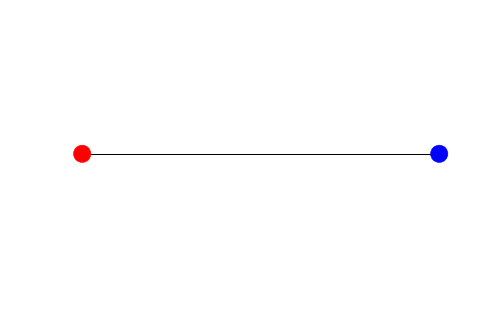

In [387]:
%time unsynchro_world(2, 100, prisoners_dilemma()).run()

### 同時更新による学習
全てのゲームを同時に行う，各ゲームで得た利得を合計した値を報酬とする

In [66]:
class synchro_world:
    def __init__(self, n_agent, n_round, payoff_matrix):
        self.n_agent = n_agent
        self.n_round = n_round
        self.action_name, self.payoff_matrix = payoff_matrix
        self.create_network(n_agent)
        
    def create_network(self, n_coop_agent):
        self.G = nx.complete_graph(n_coop_agent)
        self.n_edges = 0
        for n in self.G.nodes():
            self.n_edges += len(self.G.neighbors(n))
            agent = Q_Learning_Agent(n, sorted(self.G.neighbors(n)), [0], ['C', 'D'])
            self.G.node[n]["agent"] = agent
            self.G.node[n]["action"] = 0
            
    def run(self):
        rand = True
        for i in range(self.n_round):
            round_action_lst = []
            #全エージェントが同期的に行動選択
            if i == 5:
                rand=False
            for n in  self.G.nodes():
                self.G.node[n]["action"] = self.G.node[n]["agent"].act(0, rand)
            #報酬計算&Q値更新
            for n in self.G.nodes():
                neighbors = self.G.node[n]["agent"].get_neighbors()
                n_action = self.G.node[n]["action"]
                n_reward = 0
                for ne in neighbors:
                    ne_action = self.G.node[ne]["action"]
                    n_reward += self.payoff_matrix[n_action][ne_action][0]
                self.G.node[n]["reward"] = n_reward
                self.G.node[n]["agent"].update_q(0, n_reward)
        print(self.G.node[0]["agent"].q_table)
        print(self.G.node[1]["agent"].q_table)
        color = ["r" if self.G.node[n]["action"] == 0 else "b" for n in self.G.nodes()]
        nx.draw(self.G, pos=nx.circular_layout(self.G), node_color=color)

          0
C  1.502752
D  7.319803
          0
C  1.219392
D  7.020870


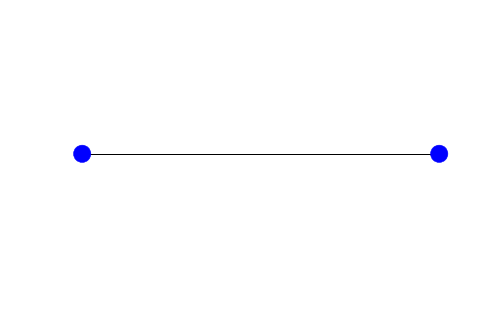

In [119]:
W = synchro_world(2, 100, prisoners_dilemma())
W.run()